<font size="+3"><strong>4.3. Predicting Damage with Decision Trees</strong></font>

In [1]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
VimeoVideo("665414130", h="71649d291e", width=600)

# Prepare Data

## Import

In [3]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 4.3.1:** Use the `wrangle` function above to import your data set into the DataFrame `df`. The path to the SQLite database is `"/home/jovyan/nepal.sqlite"`

- [<span id='technique'>Read SQL query into a DataFrame using <span id='tool'>pandas</span></span>.](../%40textbook/10-databases-sql.ipynb#Using-pandas-with-SQL-Databases)
- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)

In [4]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [5]:
# Check your work
assert df.shape[0] == 70836, f"`df` should have 70,836 rows, not {df.shape[0]}."
assert df.shape[1] == 12, f"`df` should have 12 columns, not {df.shape[1]}."

## Split

**Task 4.3.2:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

- [What's a <span id='term'>feature matrix</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Select-a-Series-from-a-DataFrame) 

In [6]:
target = "severe_damage"
X = df.drop(columns="severe_damage")
y = df["severe_damage"]

In [7]:
# Check your work
assert X.shape == (70836, 11), f"The shape of `X` should be (70836, 11), not {X.shape}."
assert y.shape == (70836,), f"The shape of `y` should be (70836,), not {y.shape}."

In [8]:
VimeoVideo("665415006", h="ecb1b87861", width=600)

**Task 4.3.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

- [<span id='technique'>Perform a randomized train-test split using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [10]:
# Check your work
assert X_train.shape == (
    56668,
    11,
), f"The shape of `X_train` should be (56668, 11), not {X_train.shape}."
assert y_train.shape == (
    56668,
), f"The shape of `y_train` should be (56668,), not {y_train.shape}."
assert X_test.shape == (
    14168,
    11,
), f"The shape of `X_test` should be (14168, 11), not {X_test.shape}."
assert y_test.shape == (
    14168,
), f"The shape of `y_test` should be (14168,), not {y_test.shape}."

**Task 4.3.4:** Divide your training data (`X_train` and `y_train`) into training and validation sets using a randomized train-test split. Your validation data should be 20% of the remaining data. Don't forget to set a `random_state`.

- [What's a <span id='term'>validation set</span>?](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)
- [<span id='technique'>Perform a randomized train-test split using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [12]:
# Check your work
assert X_train.shape == (
    45334,
    11,
), f"The shape of `X_train` should be (45334, 11), not {X_train.shape}."
assert y_train.shape == (
    45334,
), f"The shape of `y_train` should be (45334,), not {y_train.shape}."
assert X_val.shape == (
    11334,
    11,
), f"The shape of `X_val` should be (11334, 11), not {X_val.shape}."
assert y_val.shape == (
    11334,
), f"The shape of `y_val` should be (11334,), not {y_val.shape}."

# Build Model

## Baseline

**Task 4.3.5:** Calculate the baseline accuracy score for your model.

- [What's <span id='tool'>accuracy score</span>?](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [<span id='technique'>Aggregate data in a Series using `value_counts` in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)

In [13]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

In [15]:
VimeoVideo("665415061", h="6250826047", width=600)

In [16]:
VimeoVideo("665415109", h="b3bb82651d", width=600)

**Task 4.3.6:** Create a pipeline named `model` that contains a `OrdinalEncoder` transformer and a `DecisionTreeClassifier` predictor. (Be sure to set a `random_state` for your predictor.) Then fit your model to the training data. 

- [What's a <span id='term'>decision tree</span>?](../%40textbook/14-ml-classification.ipynb#Decision-Trees)
- [What's <span id='term'>ordinal encoding</span>?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Ordinal-Encoding)
- [<span id='technique'>Create a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)
- [<span id='technique'>Fit a model to training data in <span id='tool'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)

In [18]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=1)
    
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Moderate slope    1
Flat              2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
U-shape                             7
H-shape                             8
E-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
          

In [19]:
# Check your work
assert isinstance(
    model, Pipeline
), f"`model` should be a Pipeline, not type {type(model)}."
assert isinstance(
    model[0], OrdinalEncoder
), f"The first step in your Pipeline should be an OrdinalEncoder, not type {type(model[0])}."
assert isinstance(
    model[-1], DecisionTreeClassifier
), f"The last step in your Pipeline should be an DecisionTreeClassifier, not type {type(model[-1])}."
check_is_fitted(model)

In [20]:
VimeoVideo("665415153", h="f0ec320955", width=600)

**Task 4.3.7:** Calculate the training and validation accuracy scores for your models. 

- [<span id='technique'>Calculate the accuracy score for a model in <span id='term'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [<span id='technique'>Generate predictions using a trained model in <span id='term'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)

In [21]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.98
Validation Accuracy: 0.64


In [22]:
VimeoVideo("665415169", h="44702fc696", width=600)

**Task 4.3.8:** Use the [`get_depth`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.get_depth) method on the `DecisionTreeClassifier` in your model to see how deep your tree grew during training. 

- [<span id='technique'>Access an object in a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [23]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 48


In [24]:
VimeoVideo("665415186", h="c4ce187170", width=600)

**Task 4.3.9:** Create a range of possible values for `max_depth` hyperparameter of your model's `DecisionTreeClassifier`. `depth_hyperparams` should range from `1` to `50` by steps of `2`.

- [What's an <span id='term'>iterator</span>?](../%40textbook/02-python-advanced.ipynb#Iterators-and-Iterables-)
- [<span id='technique'>Create a range in <span id='tool'>Python</span></span>.](../%40textbook/17-ts-models.ipynb#Hyperparameters)

In [25]:
depth_hyperparams = range(1, 50, 2)

In [26]:
# Check your work
assert (
    len(list(depth_hyperparams)) == 25
), f"`depth_hyperparams` should contain 25 items, not {len(list(depth_hyperparams))}."
assert (
    list(depth_hyperparams)[0] == 1
), f"`depth_hyperparams` should begin at 1, not {list(depth_hyperparams)[0]}."
assert (
    list(depth_hyperparams)[-1] == 49
), f"`depth_hyperparams` should end at 49, not {list(depth_hyperparams)[-1]}."

In [27]:
VimeoVideo("665415198", h="b4b85c3308", width=600)

**Task 4.3.10:** Complete the code below so that it trains a model for every `max_depth` in `depth_hyperparams`. Every time a new model is trained, the code should also calculate the training and validation accuracy scores and append them to the `training_acc` and `validation_acc` lists, respectively. 

- [<span id='technique'>Append an item to a list in <span id='tool'>Python</span></span>.](../%40textbook/01-python-getting-started.ipynb#Appending-Items)
- [<span id='technique'>Create a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)
- [<span id='technique'>Fit a model to training data in <span id='tool'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)
- [<span id='technique'>Write a for loop in <span id='tool'>Python</span></span>.](../%40textbook/01-python-getting-started.ipynb#Python-for-Loops)

In [33]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(), DecisionTreeClassifier(max_depth = d, random_state=1)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7037984735518595, 0.709092513345392, 0.7125556977103278]
Validation Accuracy Scores: [0.7048703017469561, 0.7092818069525322, 0.7107817187224281]


In [29]:
# Check your work
assert (
    len(training_acc) == 25
), f"`training_acc` should contain 25 items, not {len(training_acc)}."
assert (
    len(validation_acc) == 25
), f"`validation_acc` should contain 25 items, not {len(validation_acc)}."

In [30]:
VimeoVideo("665415236", h="51d4be13fa", width=600)

**Task 4.3.11:** Create a visualization with two lines. The first line should plot the `training_acc` values as a function of `depth_hyperparams`, and the second should plot `validation_acc` as a function of `depth_hyperparams`. You x-axis should be labeled `"Max Depth"`, and the y-axis `"Accuracy Score"`. Also include a legend so that your audience can distinguish between the two lines. 

- [What's a <span id='term'>line plot</span>?](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)
- [<span id='technique'>Create a line plot in <span id='tool'>Matplotlib</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

Text(0, 0.5, 'Accuracy Score')

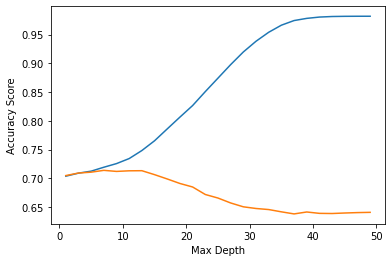

In [34]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")

## Evaluate

In [37]:
VimeoVideo("665415255", h="573e9cfd74", width=600)

**Task 4.3.12:** Based on your visualization, choose the `max_depth` value that leads to the best validation accuracy score. Then retrain your original model with that `max_depth` value. Lastly, check how your tuned model performs on your test set by calculating the test accuracy score below. Were you able to resolve the overfitting problem with this new `max_depth`?

- [<span id='technique'>Calculate the accuracy score for a model in <span id='term'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [<span id='technique'>Generate predictions using a trained model in <span id='term'>scikit-learn</span></span>.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)

In [42]:
fin_model = make_pipeline(
        OrdinalEncoder(), DecisionTreeClassifier(max_depth = 8, random_state=1)
    )
fin_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Moderate slope    1
Flat              2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
E-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                   

In [43]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_test, y_test)

In [44]:
acc_val

0.6437041219649915

In [45]:
test_acc = fin_model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.72


# Communicate

In [46]:
VimeoVideo("665415275", h="880366a826", width=600)

**Task 4.3.13:** Complete the code below to use the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function from scikit-learn to visualize the decision logic of your model. 

- [<span id='technique'>Plot a decision tree using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Plotting-a-Decision-Tree)

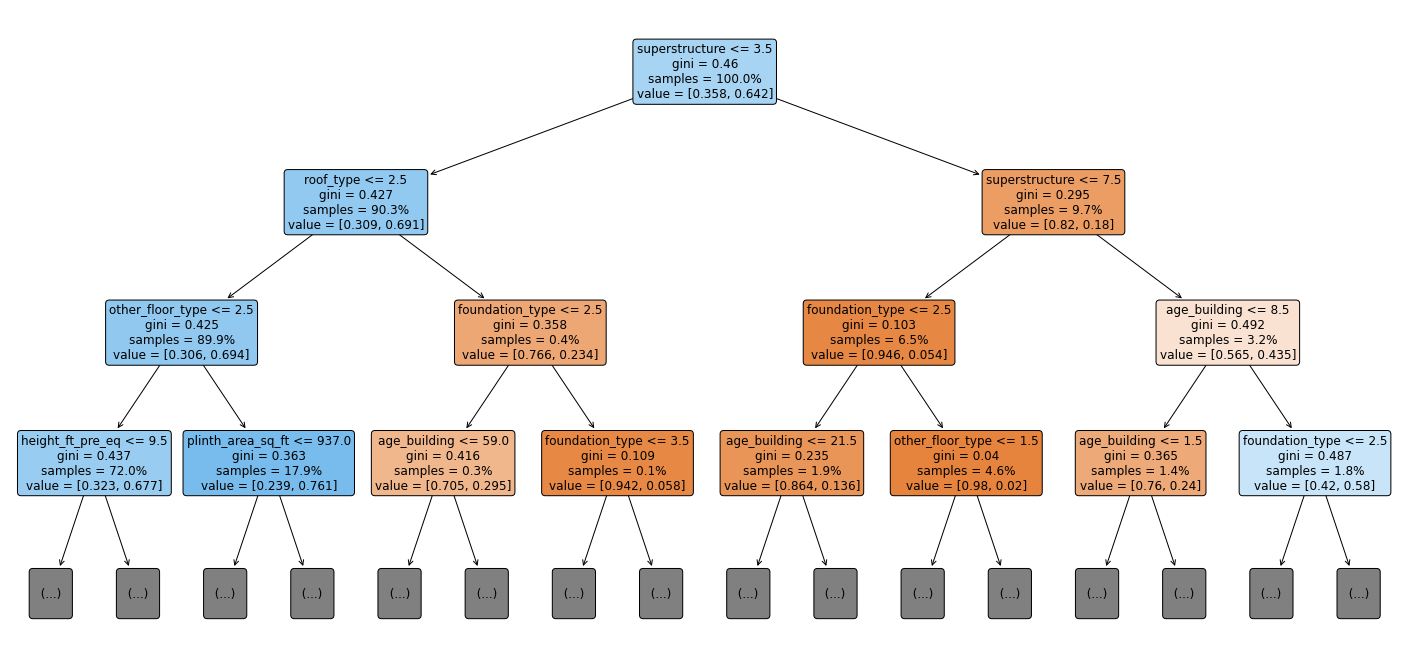

In [48]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [49]:
VimeoVideo("665415304", h="c7eeac08c9", width=600)

**Task 4.3.14:** Assign the feature names and importances of your model to the variables below. For the `features`, you can get them from the column names in your training set. For the `importances`, you access the [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of your model's `DecisionTreeClassifier`. 

- [<span id='technique'>Access an object in a pipeline in <span id='tool'>scikit-learn</span></span>.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [50]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.25594478 0.37565889 0.07216076]


In [51]:
# Check your work
assert len(features) == 11, f"`features` should contain 11 items, not {len(features)}."
assert (
    len(importances) == 11
), f"`importances` should contain 11 items, not {len(importances)}."

**Task 4.3.15:** Create a pandas Series named `feat_imp`, where the index is `features` and the values are your `importances`. The Series should be sorted from smallest to largest importance.

- [<span id='technique'>Create a Series in <span id='tool'>pandas</span></span>.](../%40textbook/03-pandas-getting-started.ipynb#Adding-Columns)

In [52]:
feat_imp = pd.Series(importances, index=features)
feat_imp.head()

age_building              0.255945
plinth_area_sq_ft         0.375659
height_ft_pre_eq          0.072161
land_surface_condition    0.029891
foundation_type           0.018166
dtype: float64

In [53]:
# Check your work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a Series, not {type(feat_imp)}."
assert feat_imp.shape == (
    11,
), f"`feat_imp` should have shape (11,), not {feat_imp.shape}."

In [ ]:
VimeoVideo("665415316", h="0dd9004477", width=600)

**Task 4.3.16:** Create a horizontal bar chart with all the features in `feat_imp`. Be sure to label your x-axis `"Gini Importance"`.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [<span id='technique'>Create a bar chart using <span id='tool'>pandas</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)

Text(0.5, 0, 'Gini Importance')

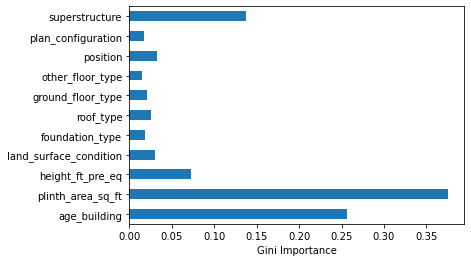

In [55]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
